In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import time

In [4]:
from rxrmask.core import (
    Atom,
    Structure,
    FormFactorLocalDB,
    ParametersContainer,
    create_compound,
    load_reflectivity_scans
)
from rxrmask.utils import (
    plot_reflectivity,
    plot_energy_scan,
    plot_density_profile,
    get_density_profile_from_element_data,
)
from rxrmask.backends import (
    PRReflectivityBackend,
    PRParallelReflectivityBackend,
)

In [5]:
o_ff = FormFactorLocalDB(element="O", is_magnetic=False)
sr_ff = FormFactorLocalDB(element="Sr", is_magnetic=False)
ti_ff = FormFactorLocalDB(element="Ti", is_magnetic=False)
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)

In [62]:
parameters_container = ParametersContainer()
crystal = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3-crystal",
    formula="Sr:1,Ti:1,O:3",
    thickness=50.0,
    density=5.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=2.0,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)
film = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3-film",
    formula="Sr:1,Ti:1,O:3",
    thickness=23.0,
    density=5.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=4.0,
    prev_roughness=0.0,
    linked_prev_roughness=True,
)

n_layers = 100
total_thickness = crystal.thickness.get() + film.thickness.get()


struc = Structure(name="SrTiO3-struc", n_compounds=2, params_container=parameters_container)
struc.add_compound(0, crystal)
struc.add_compound(1, film)
struc.validate_compounds()
struc.create_layers(step=total_thickness/n_layers)

print(f"number of layers: {struc.n_layers}")

number of layers: 121


In [7]:
init_params = parameters_container.get_fit_vector()
print(f"Initial parameters: {init_params}")
for param in parameters_container.parameters:
    if param.fit:
        print(f"{param.name}: {param.value}")

Initial parameters: []


Reflectivity calculation time: 0.0329 seconds


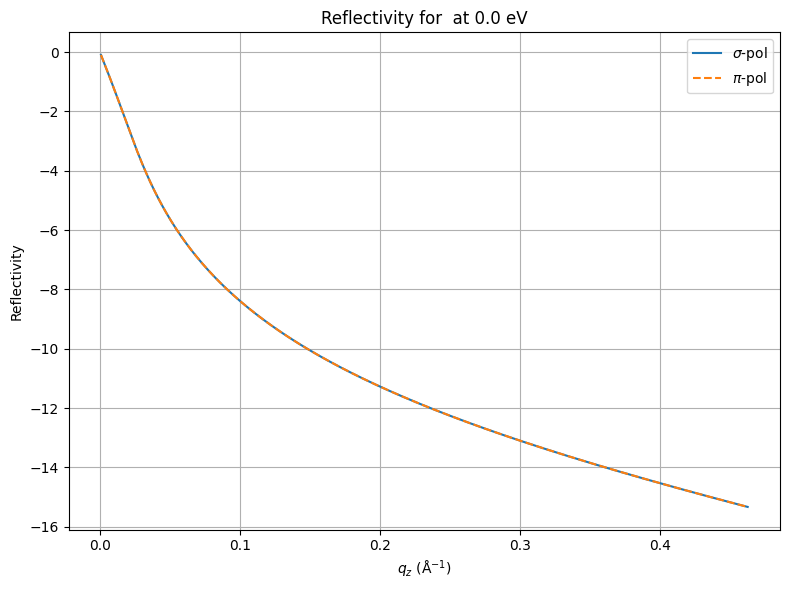

In [63]:
backend = PRReflectivityBackend(als=False)

E_eV = 456.8
Theta = np.linspace(0.1, 89.1, num=1001)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)

init_time = time.perf_counter()
initial_ref = backend.compute_reflectivity(structure=struc, qz=qz, energy=E_eV)
end_time = time.perf_counter()
print(f"Reflectivity calculation time: {end_time - init_time:.4f} seconds")
plot_reflectivity(initial_ref.qz, np.log(initial_ref.R_s), np.log(initial_ref.R_s), initial_ref.energy, "")


Reflectivity calculation time (parallel): 0.1744 seconds


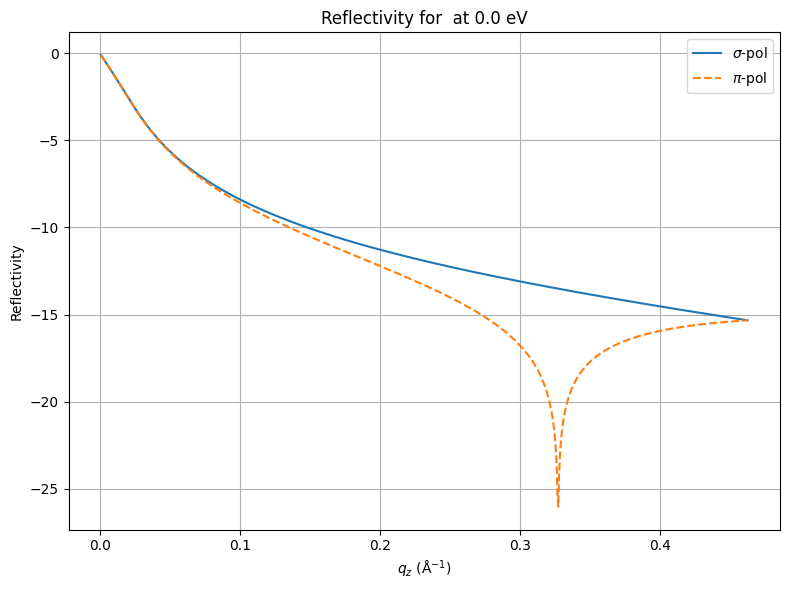

In [64]:
backend_parallel = PRParallelReflectivityBackend(als=False, use_threads=False)

E_eV = 456.8
Theta = np.linspace(0.1, 89.1, num=1001)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)

init_time = time.perf_counter()
initial_ref = backend_parallel.compute_reflectivity(structure=struc, qz=qz, energy=E_eV)
end_time = time.perf_counter()
print(f"Reflectivity calculation time (parallel): {end_time - init_time:.4f} seconds")
plot_reflectivity(initial_ref.qz, np.log(initial_ref.R_s), np.log(initial_ref.R_p), initial_ref.energy, "")

Energy scan calculation time: 0.1684 seconds


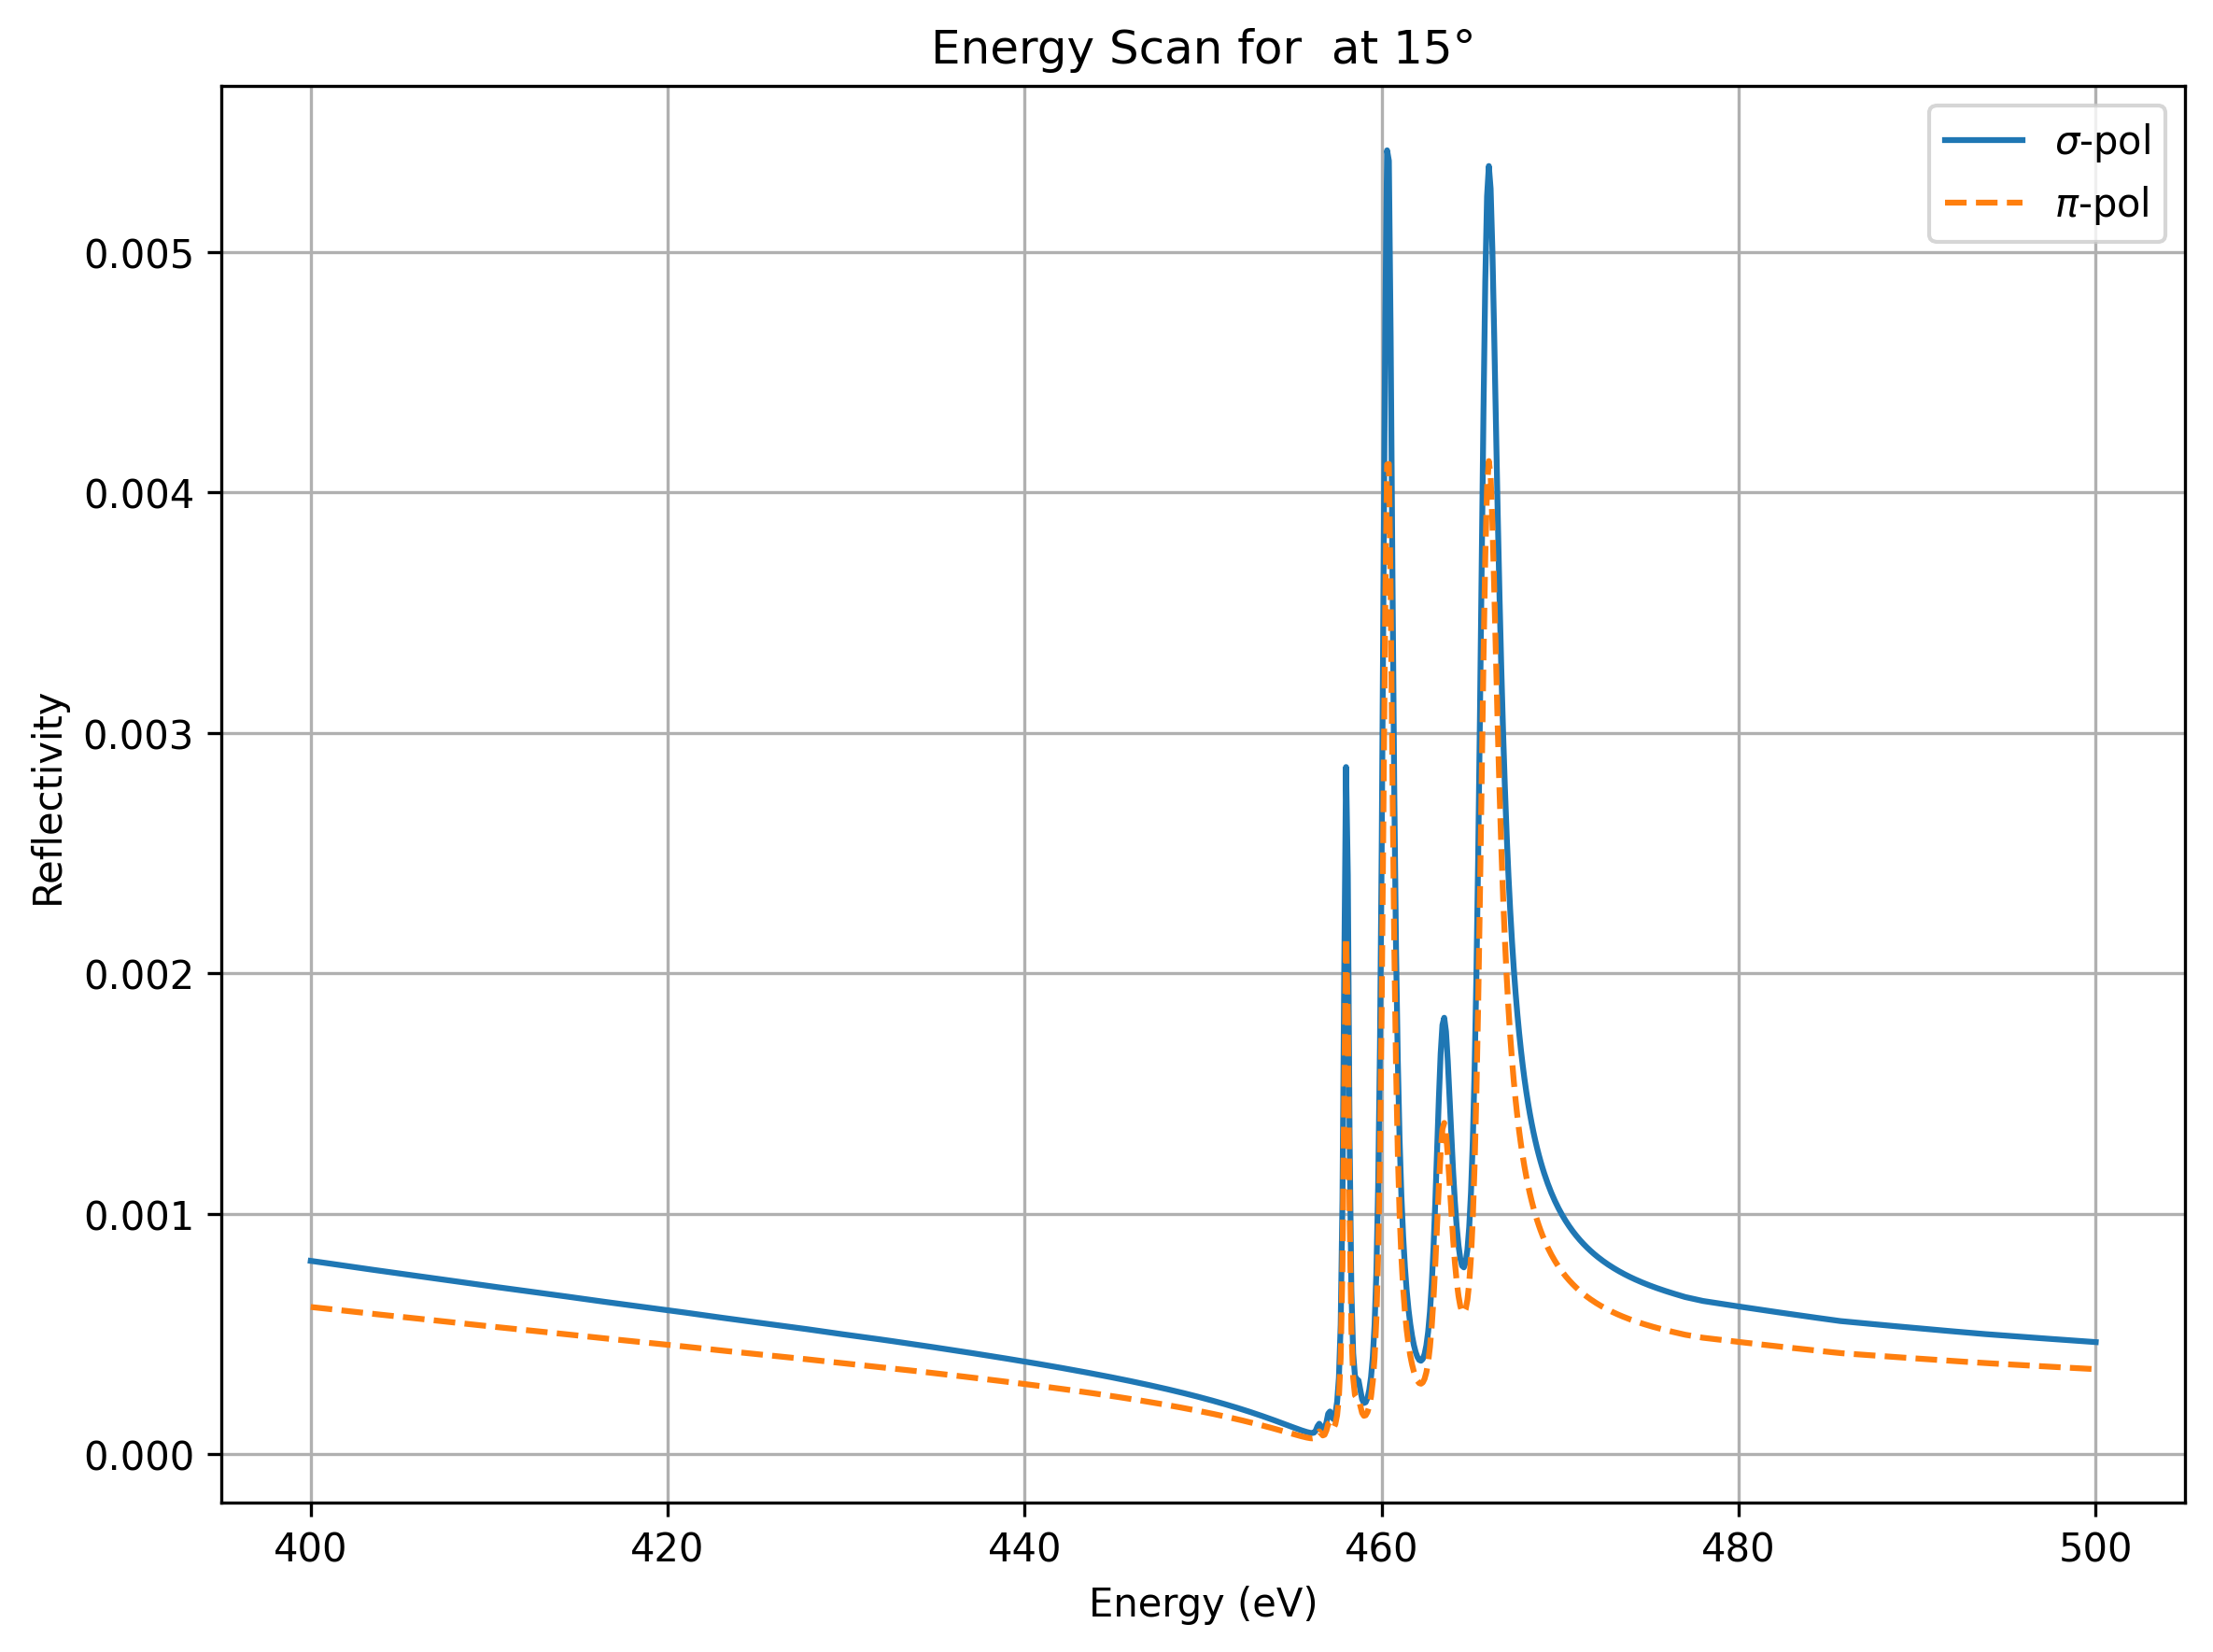

In [66]:
E_eV = np.linspace(400, 500, num=1001)
Theta = 15

init_time = time.perf_counter()
energy_scan = backend.compute_energy_scan(structure=struc, energy_range=E_eV, theta=Theta)
end_time = time.perf_counter()
print(f"Energy scan calculation time: {end_time - init_time:.4f} seconds")
plot_energy_scan(energy_scan.energy_range, energy_scan.R_s, energy_scan.R_p, Theta, "")

Energy scan calculation time (parallel): 0.1499 seconds


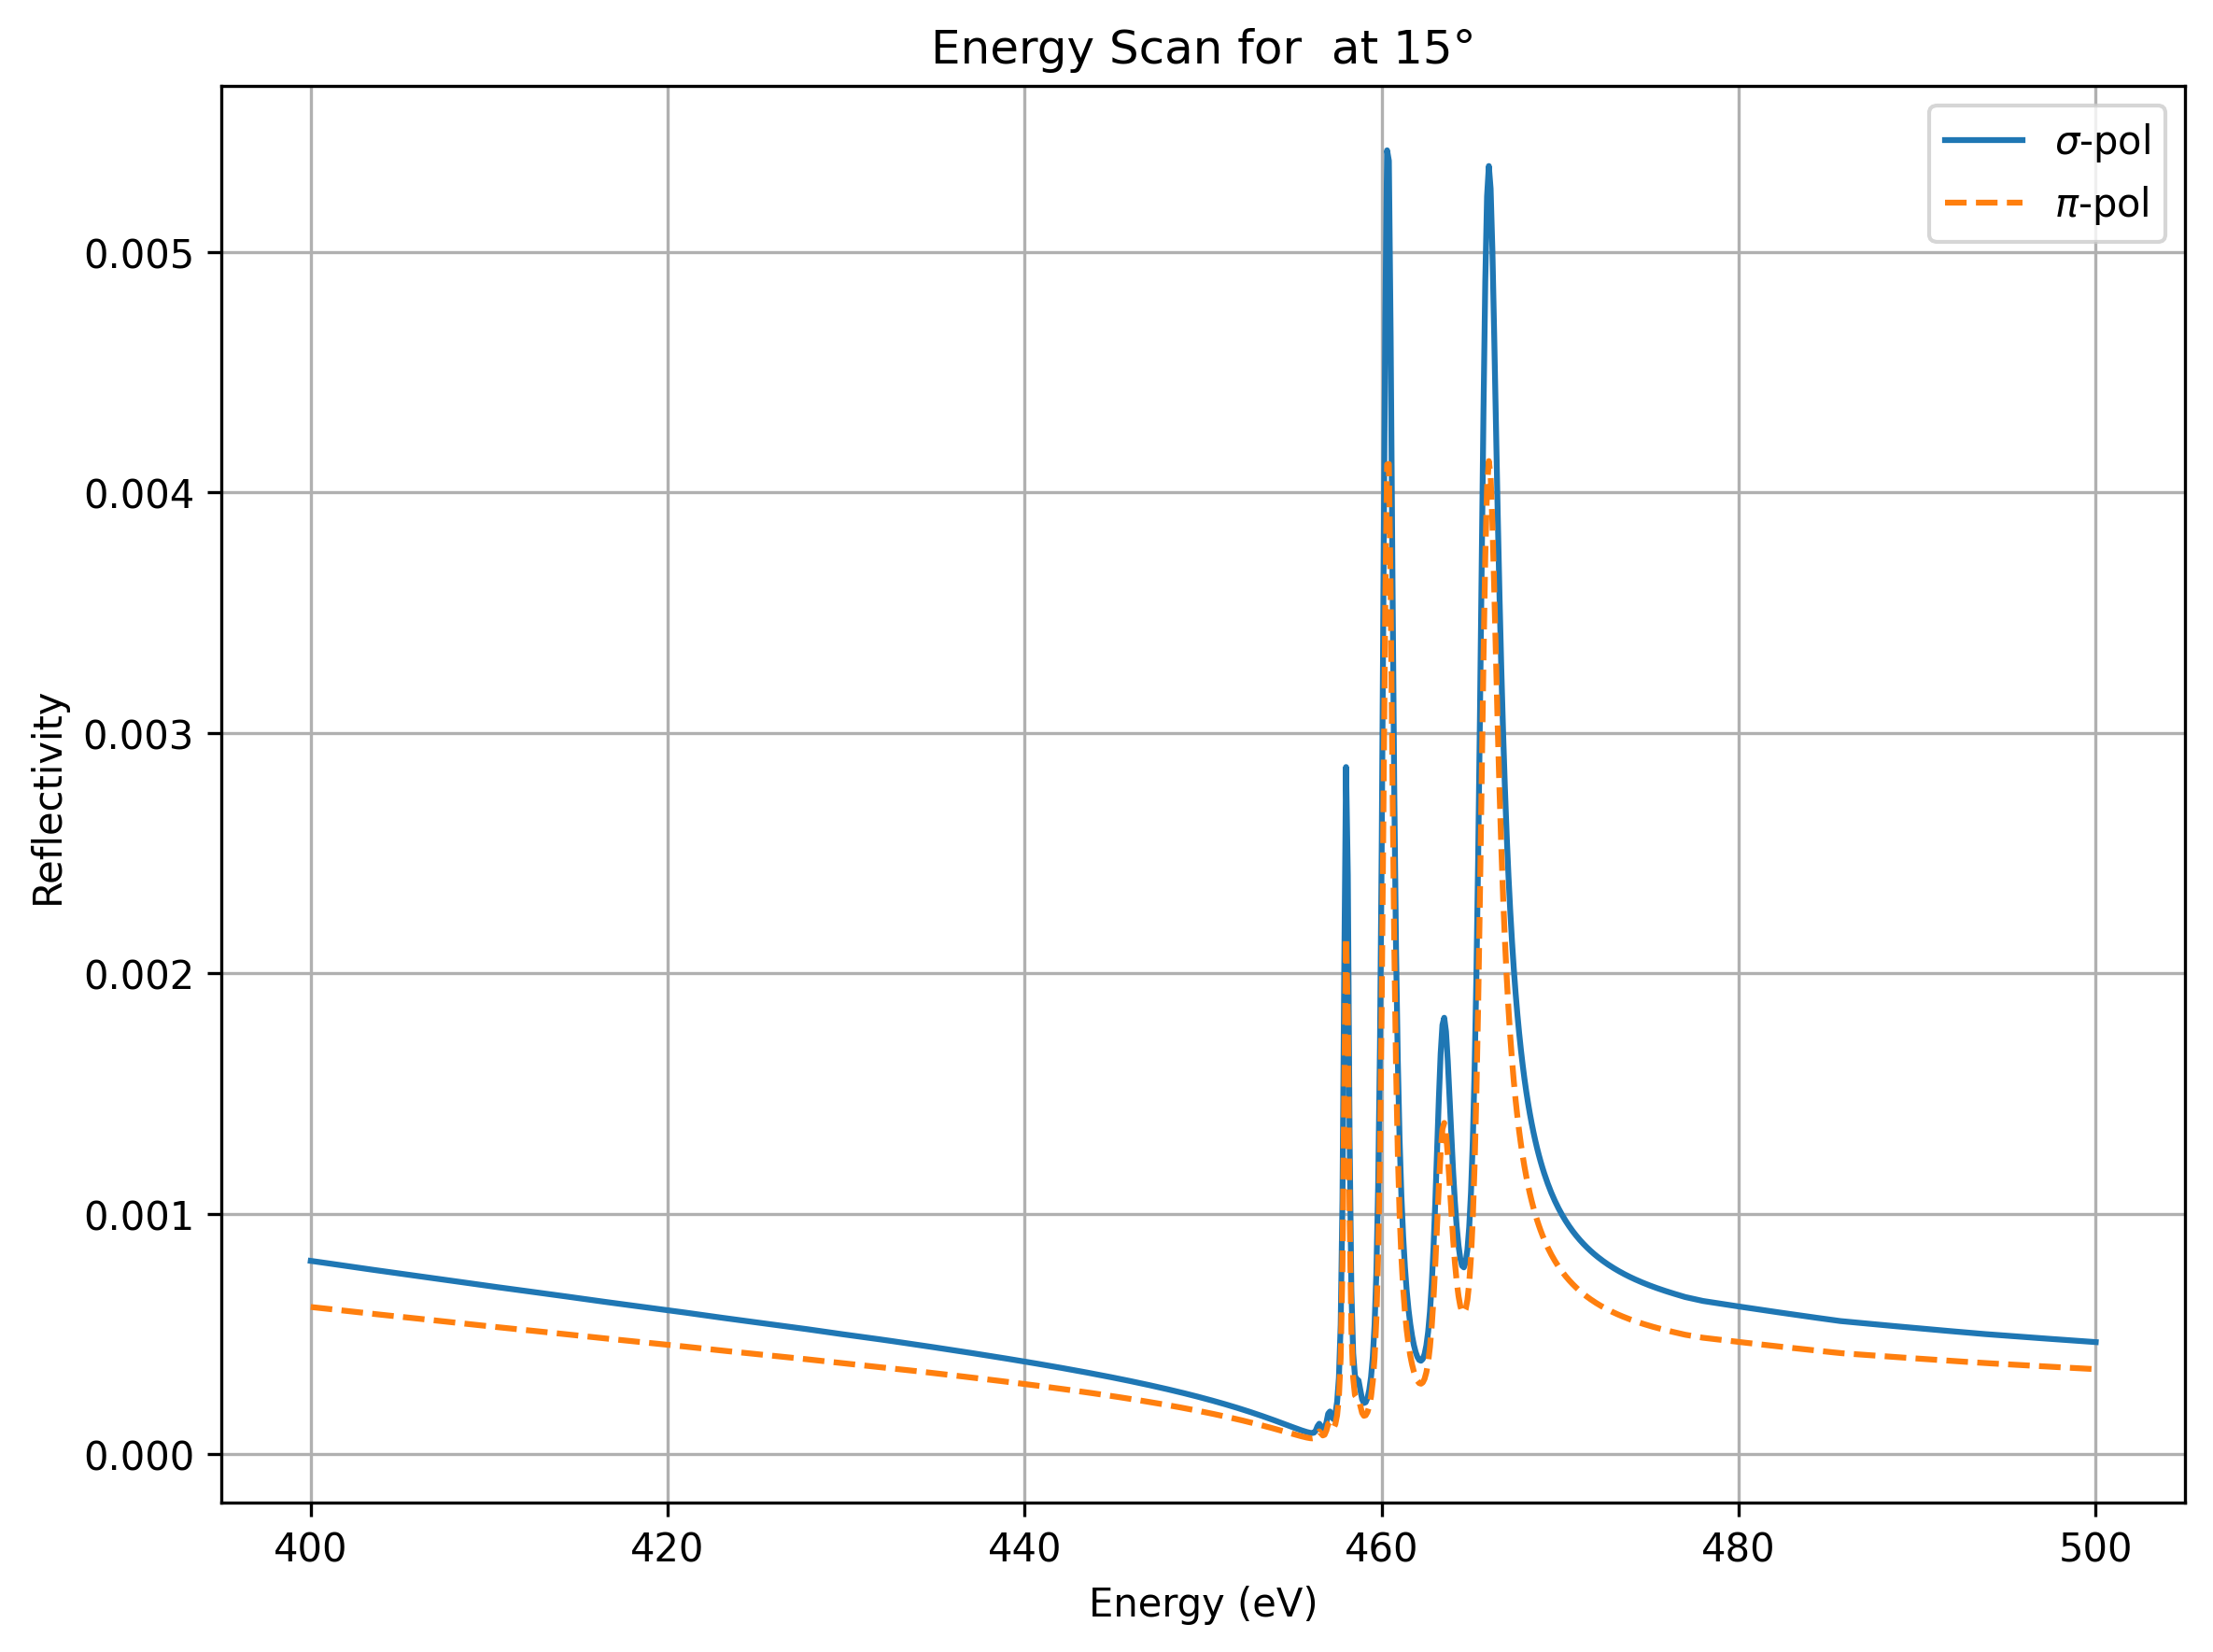

In [69]:
E_eV = np.linspace(400, 500, num=1001)
Theta = 15

init_time = time.perf_counter()
energy_scan = backend_parallel.compute_energy_scan(structure=struc, energy_range=E_eV, theta=Theta)
end_time = time.perf_counter()
print(f"Energy scan calculation time (parallel): {end_time - init_time:.4f} seconds")
plot_energy_scan(energy_scan.energy_range, energy_scan.R_s, energy_scan.R_p, Theta, "")

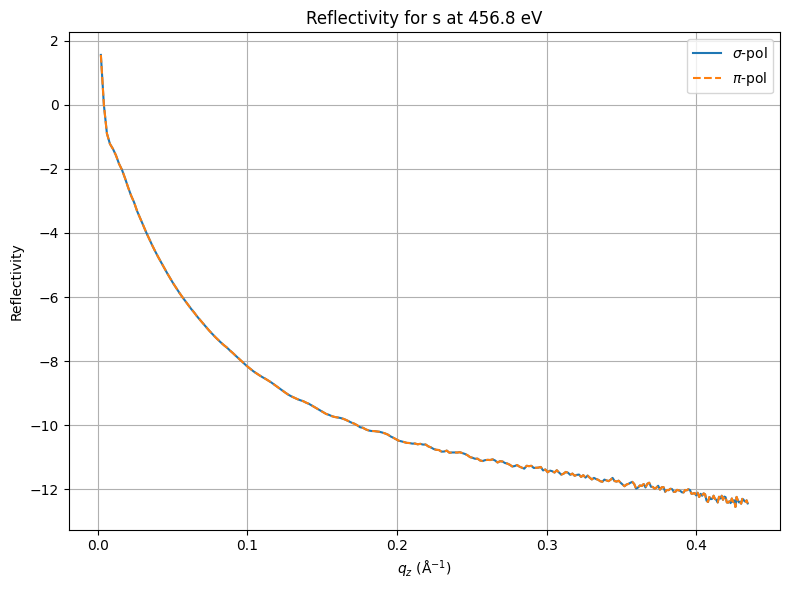

In [29]:
experimental_scans = load_reflectivity_scans(
    path='/Users/niaggar25/Downloads/Experimental RXR data/B074_AScans.dat',
    initial_name='B074_AScans',
)

i = 0
exp_data_test = experimental_scans[i]
plot_reflectivity(exp_data_test.qz, np.log(exp_data_test.R), np.log(exp_data_test.R), exp_data_test.energy_eV, f"{exp_data_test.pol}")